In [1]:
import healpy as hp
import numpy as np
import matplotlib as mpl
import matplotlib.image
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import colors
from matplotlib import lines
from matplotlib.image import NonUniformImage
import astropy.io
from astropy.io import fits
from astropy import units as u
from astropy.units import cds
from astropy import constants as const
import random
import scipy
import scipy.integrate as integrate
from scipy import stats

In [2]:
#imports all the important maps that we'll use throughout the notebook

m = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=1)    #reads mean amplitude primary map
nu_p = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=4, hdu=1) #reads mean peak freqeuncy primary map
n = hp.read_map('COM_CompMap_AME-commander_0256_R2.00.fits', field=1, hdu=2)    #same secondary map
hdu = fits.open("COM_CompMap_AME-commander_0256_R2.00.fits")                    #opens map header for frequency template
data = hdu[3].data                                                              #takes array from hdu[3]
nu_sd = np.array([i[0] for i in data])                                          #creates an array of template frequency
f = np.array([i[1] for i in data])                                              #creates an array of spdust2 spectrum
h = hp.read_map('mom0_-90_90_1024.hpx.fits')                                    #reads map of HI column denisty
nh = hp.pixelfunc.ud_grade(h, 256)                                              #degrades to NPIX = 256
CNM = hp.read_map('fcnm_hi4pi_hpx.fits')                                        #reads map of CNM fraction
f_CNM = hp.ud_grade(CNM, 256)                                                   #degrades to NPIX = 256

/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


Ordering converted to RING
NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


/home/mdodici/anaconda3/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)


In [4]:
def I(A1, A2, nu_p1, nu_sd, f, nu):
    ''' Calculate a specific intensity curve for a pixel at either a range or a specific value of nu. First three args
        should be either all floats or all arrays; if arrays, nu should be float, otherwise nu can be either.
        
        Input:  A1: float or array, amplitude from primary map
                A2: float or array, amplitude from secondary map
                nu_p1: float or array, peak frequency from primary map
                nu_sd: array, template frequency
                f: array, template frequency 
                nu: float or array, range of frequencies over which to evaluate the function
        
        Return: array of shape [1,n] (if first three args are floats); 
                  --> values of specific intensity in MJy/sr for each of the n discrete values of nu
                array of shape [n,1] (if first three args are arrays);
                  --> values of specific intensity in MJy/sr at a given nu for each pixel of a map
    '''
    nu_p0 = 30. 
    nu_p2 = 33.35 #sets frequency peak for all secondary pixels
    nu_01 = 22.8 #sets reference freq for primary pixels
    nu_02 = 41.0 #sets reference freq for secondary pixels
    nu_1 = nu_01*(nu_p0/nu_p1) #sets the value nu1 for f_sd1
    nu_2 = nu_02*(nu_p0/nu_p2) #same for 2
    nu_fsd1 = nu*(nu_p0/nu_p1)
    nu_fsd2 = nu*(nu_p0/nu_p2)
    
    f_sd1 = np.interp(nu_1, nu_sd, f) #interpolates nu_sd and f to create f_sd1 at nu1
    f_sd2 = np.interp(nu_2, nu_sd, f) #same for 2
    f_nu1 = np.interp(nu_fsd1, nu_sd, f) #same for general nu
    f_nu2 = np.interp(nu_fsd2, nu_sd, f) #same for general nu
    
    I_1 = A1*((nu_01/nu)**2)*(f_nu1/f_sd1) #component from primary 
    I_2 = A2*((nu_02/nu)**2)*(f_nu2/f_sd2) #component from secondary
    m_K1 = I_1*u.K*(2*(nu*u.GHz)**2*const.k_B)/(const.c**2*cds.sr) #adds units to primary
    m_K2 = I_2*u.K*(2*(nu*u.GHz)**2*const.k_B)/(const.c**2*cds.sr) #same for secondary
    m_J1 = m_K1.to(cds.MJy/cds.sr)
    m_J2 = m_K2.to(cds.MJy/cds.sr)
    m_J = m_J1 + m_J2
    return m_J * cds.sr/cds.MJy #gets rid of units for plotting purposes

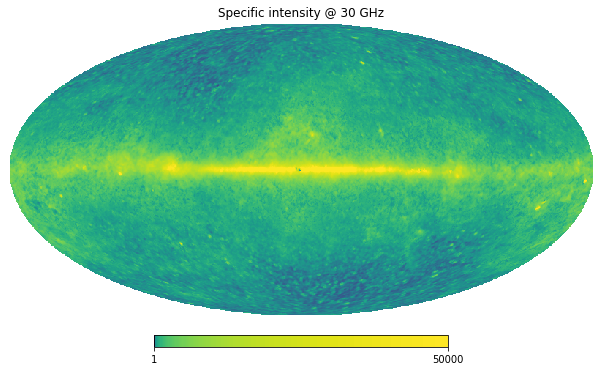

In [5]:
nu = np.linspace(1, 100, len(m))
I_map = I(m, n, nu_p, nu_sd, f, 40)

hp.mollview(I_map, min=1, max=5e4, title='Specific intensity @ 30 GHz', norm='log')

In [60]:
def finite_fCNM(i,t):
    '''Limits our work to just pixels where fCNM is a valid value (i.e. non-negative and finite)
       
       Input:
        i: map
        t: array of sample pixels
        
       Return:
        Array of the sample pixels of the map for which f_CNM is both finite and above .0128'''
    
    l = []
    for a in t:
        if np.isfinite(f_CNM[a]) == 1 and f_CNM[a] > 0.001:
            l.append(i[a])
    return np.array(l)

t = np.random.choice(np.arange(len(f_CNM)), 100000, replace=False)

a1 = finite_fCNM(m,t)
a2 = finite_fCNM(n,t)
nup1 = finite_fCNM(nu_p,t)
fCNM = finite_fCNM(f_CNM,t)
N_HI = finite_fCNM(nh,t)

/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


Pixel 0
330232 b
f_CNM: 21.281591709703207
A1: 212.73878479003906
A2: 31.626413345336914
nu_p1: 18.994400024414062
Pixel 1
339181 r
f_CNM: -1.6374999999999998e+32
A1: 445.1552429199219
A2: 75.01144409179688
nu_p1: 18.73509979248047
Pixel 2
396813 g
f_CNM: 11.675909208133817
A1: 2386.969482421875
A2: 372.6387939453125
nu_p1: 18.899293899536133
Pixel 3
387586 c
f_CNM: 10.057409387081861
A1: 2506.9931640625
A2: 522.1303100585938
nu_p1: 19.279830932617188


Text(0, 0.5, 'Specific Intensity (MJy/sr)')

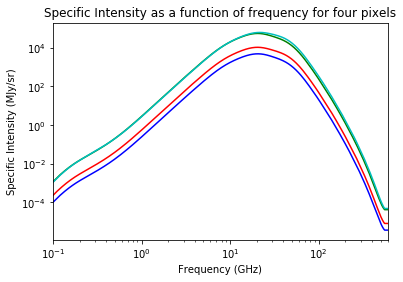

In [8]:
# This cell plots four random pixels and prints
# their f_CNM values in an attempt to see if there 
# is any relation between the two.

mask_ones = np.ones_like(CNM)                     #creates an array of 1s the size and shape of CNM
mask_zeros = np.where(CNM < 0, 0, mask_ones)      #sets mask_one values to 0 where the f_CNM is unreasonable
mask_map = hp.pixelfunc.ud_grade(mask_zeros, 256) #degrades mask array to the right NSIDE
mask = np.where(mask_map < 1, 0, mask_map)        #sets mask values to 0 where mask value is not 1
masked_fCNM = f_CNM[mask == 1]                    #masks fCNM map to just reasonable values

m_mask = m[mask == 1]
nu_p_mask = nu_p[mask == 1]
n_mask = n[mask == 1]

pix = []
for i in range(4):
    x = random.randint(330000, 400000)
    pix.append(x)

b = len(pix) #number of pixels to be plotted
nu = np.linspace(.1, 1000, len(m)) #creates a range of values nu

for i in range(b):
    a1_i = m_mask[pix[i]] #sets A1 for the ith random pixel
    a2_i = n_mask[pix[i]] #sets A2 for the ith random pixel
    nup1_i = nu_p_mask[pix[i]] #sets nu_p1 for the ith random pixel
    
    I_nui = I(a1_i, a2_i, nup1_i, nu_sd, f, nu) #sets I_nu(nu) for the ith random pixel
    
    color = ['b', 'r', 'g', 'c', 'm', 'y', 'k'] #creates an array of four different color possibilities
    print('Pixel ' + str(i))
    print(pix[i], color[i])
    
    plt.plot(nu, I_nui, color[i]) #plots I_nu(nu) for each pixel, each in a different color
    print('f_CNM: ' + str(masked_fCNM[pix[i]]*100))
    print('A1: ' + str(a1_i))
    print('A2: ' + str(a2_i))
    print('nu_p1: ' + str(nup1_i))

plt.yscale('log')
plt.xscale('log')
plt.xlim(.1,600)
plt.title('Specific Intensity as a function of frequency for four pixels')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Specific Intensity (MJy/sr)')

Text(0, 0.5, 'nu_p1')

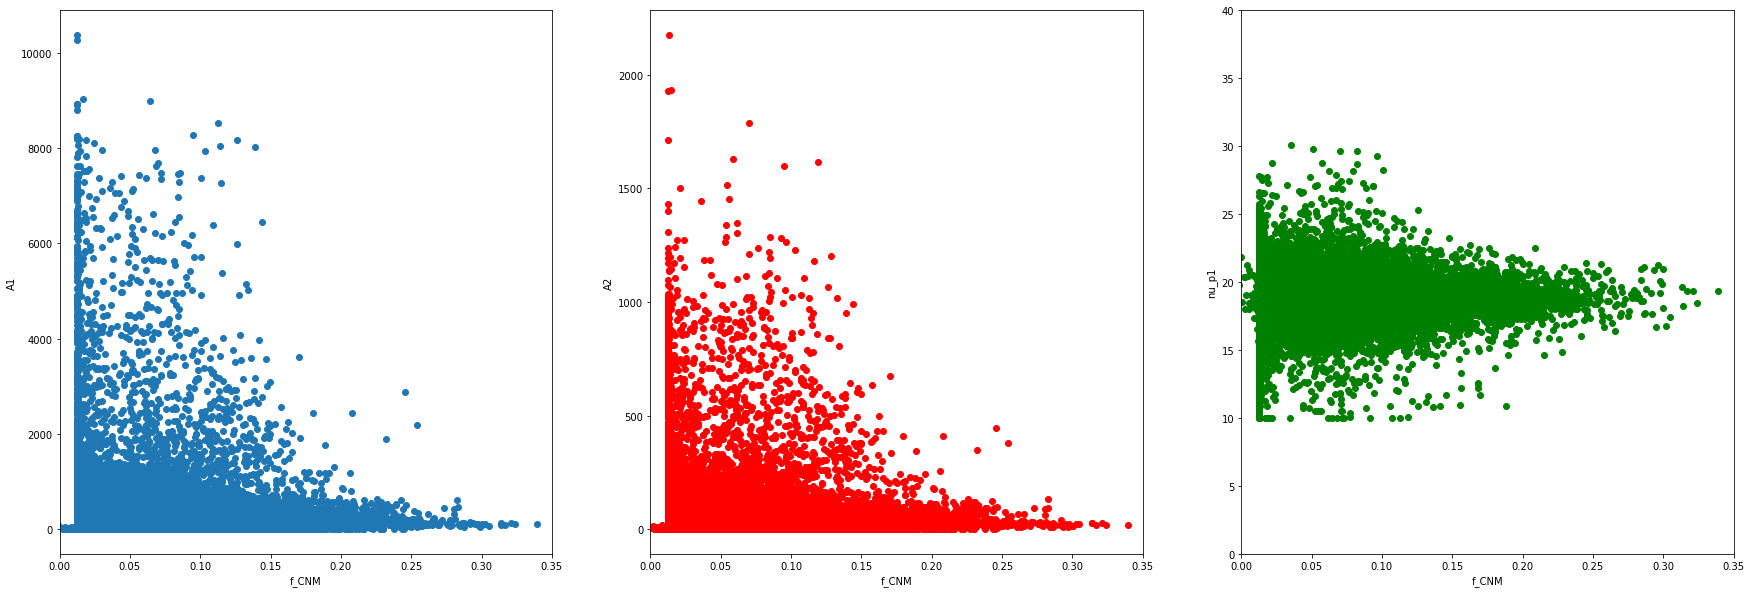

In [9]:
# Looks for general trends in the primary and secondary amplitude vs. f_CNM (blue and red)
# and in peak frequency vs. f_CNM (green)

idx = np.random.choice(np.arange(len(m)), 100000, replace=False)
a1 = m[idx]
a2 = n[idx]
nup1 = nu_p[idx]
fCNM = f_CNM[idx]

fig, ax = plt.subplots(1,3, figsize=(30,10))

for i in range(3):
    ax[i].set_xlim(0, .35)

ax[0].scatter(fCNM, a1)
ax[0].set_xlabel("f_CNM")
ax[0].set_ylabel("A1")
plt.ylim(0, 12000)
ax[1].scatter(fCNM, a2, c='r')
plt.ylim(0, 2500)
ax[1].set_xlabel("f_CNM")
ax[1].set_ylabel("A2")
ax[2].scatter(fCNM, nup1, c='g')
plt.ylim(0, 40)
ax[2].set_xlabel("f_CNM")
ax[2].set_ylabel("nu_p1")
#plt.yscale('log')
#plt.xscale('log')
#plt.ylim(-1, 2000)

4.412955465587045
0.4432661717921527
34.276729559748425
4.977831519548569


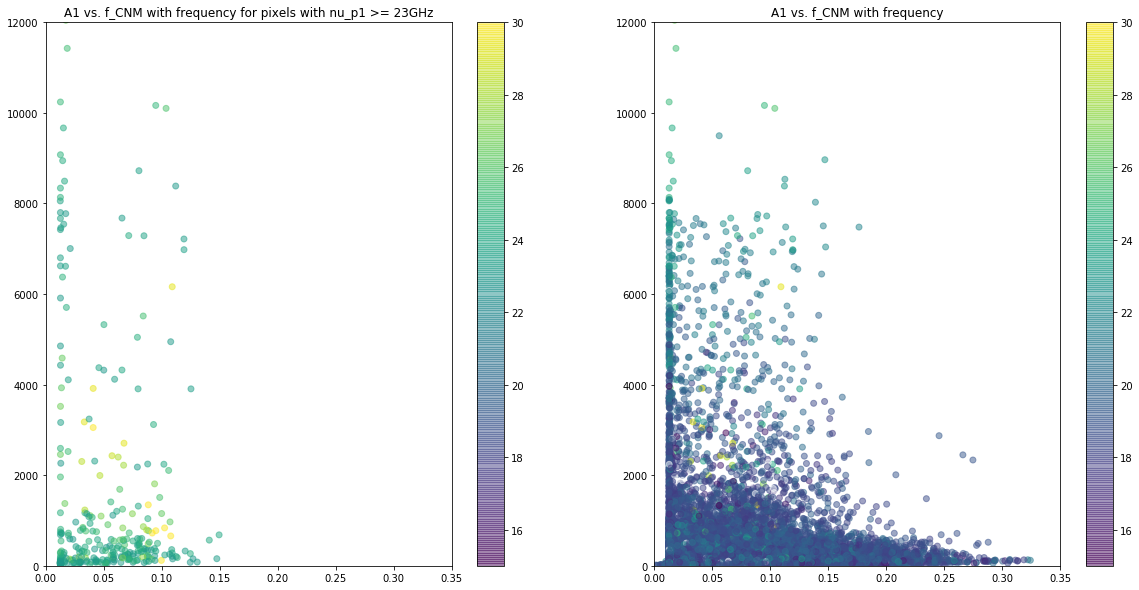

In [11]:
# Makes two scatter plots displaying A1 vs. fCNM for a number of pixels.
# First plot shows only those pixels with a peak frequency above a certain cutoff (lim) while second plot shows all pixels. 
# 
# Also prints four percentages: 
#    high frequency pixels out of high amplitude pixels
#    high frequency pixels out of low amplitude pixels 
#    high amplitude pixels out of high frequency pixels
#    high amplitude pixels out of all pixels

lim = 23
a1_hi = []
fCNM_hi = []
nup1_hi = []
for x in range(len(fCNM)):
    if nup1[x] >= lim:
        a1_hi.append(a1[x])
        fCNM_hi.append(fCNM[x])
        nup1_hi.append(nup1[x])

hia_hinup = sum(1 if a1[i] >= 750 and nup1[i] >= lim else 0 for i in range(len(a1)))#number of points at high a1 with nup1 above limit
loa_hinup = sum(1 if a1[i] < 750 and nup1[i] >= lim else 0 for i in range(len(a1))) #number of points at low a1 with nup1 above limit
hia = sum(1 if a1[i] >= 750 else 0 for i in range(len(a1)))
loa = sum(1 if a1[i] < 750 else 0 for i in range(len(a1)))

fig, ax = plt.subplots(1,2, figsize=(20,10))

#plots points of nu_p1 greater than a certain limit
a = ax[0].scatter(fCNM_hi, a1_hi, alpha=.5, c=nup1_hi, vmin=15, vmax=30)
ax[0].set_ylim(0,12000)
ax[0].set_xlim(0,.35)
ax[0].set_title('A1 vs. f_CNM with frequency for pixels with nu_p1 >= ' + str(lim) + 'GHz')
fig.colorbar(a, ax=ax[0])

#plots all 100000 points
b = ax[1].scatter(fCNM, a1, alpha=.5, c=nup1, vmin=15, vmax=30)
ax[1].set_ylim(0,12000)
ax[1].set_xlim(0,.35)
ax[1].set_title('A1 vs. f_CNM with frequency')
fig.colorbar(b, ax=ax[1])

print(100*hia_hinup/hia) #Percent of high A1 vals with hi nup1: 
print(100*loa_hinup/loa) #Percent of low A1 vals with hi nup1:
print(100*hia_hinup/(hia_hinup+loa_hinup)) #Percent of hi nup1 pixels with hi A1:
print(100*hia/(hia+loa)) #Percent of pixels with hi A1:

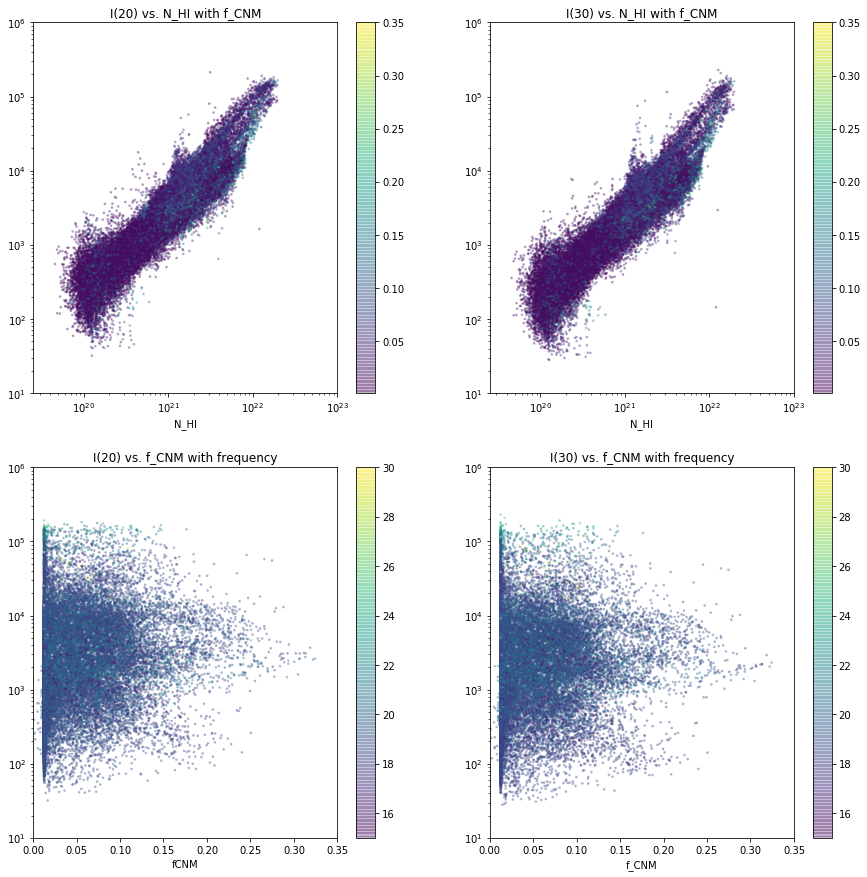

In [21]:
N_CNM = fCNM * N_HI

I30 = I(a1, a2, nup1, nu_sd, f, 30)
I20 = I(a1, a2, nup1, nu_sd, f, 20)

fig, ax = plt.subplots(2,2, figsize=(15, 15))

#plots all 100000 points
a = ax[0,0].scatter(N_HI, I20, s=3, alpha=.3, c=fCNM, vmin=.001, vmax=.35)
ax[0,0].set_xlim(2.5e19, 1e23)
ax[0,0].set_ylim(10, 1e6)
ax[0,0].set_xscale('log')
ax[0,0].set_yscale('log')
ax[0,0].set_xlabel('N_HI')
ax[0,0].set_title('I(20) vs. N_HI with f_CNM')
fig.colorbar(a, ax=ax[0,0])

b = ax[0,1].scatter(N_HI, I30, s=3, alpha=.3, c=fCNM, vmin=.001, vmax=.35)
ax[0,1].set_xlim(2.5e19, 1e23)
ax[0,1].set_ylim(10, 1e6)
ax[0,1].set_xscale('log')
ax[0,1].set_yscale('log')
ax[0,1].set_xlabel('N_HI')
ax[0,1].set_title('I(30) vs. N_HI with f_CNM')
fig.colorbar(b, ax=ax[0,1])

c = ax[1,0].scatter(fCNM, I20, s=3, alpha=.3, c=nup1, vmin=15, vmax=30)
ax[1,0].set_xlim(0, 0.35)
ax[1,0].set_ylim(10, 1e6)
ax[1,0].set_yscale('log')
ax[1,0].set_xlabel('fCNM')
ax[1,0].set_title('I(20) vs. f_CNM with frequency')
fig.colorbar(c, ax=ax[1,0])

d = ax[1,1].scatter(fCNM, I30, s=3, alpha=.3, c=nup1, vmin=15, vmax=30)
ax[1,1].set_xlim(0, 0.35)
ax[1,1].set_ylim(10, 1e6)
ax[1,1].set_yscale('log')
ax[1,1].set_xlabel('f_CNM')
ax[1,1].set_title('I(30) vs. f_CNM with frequency')
fig.colorbar(d, ax=ax[1,1])

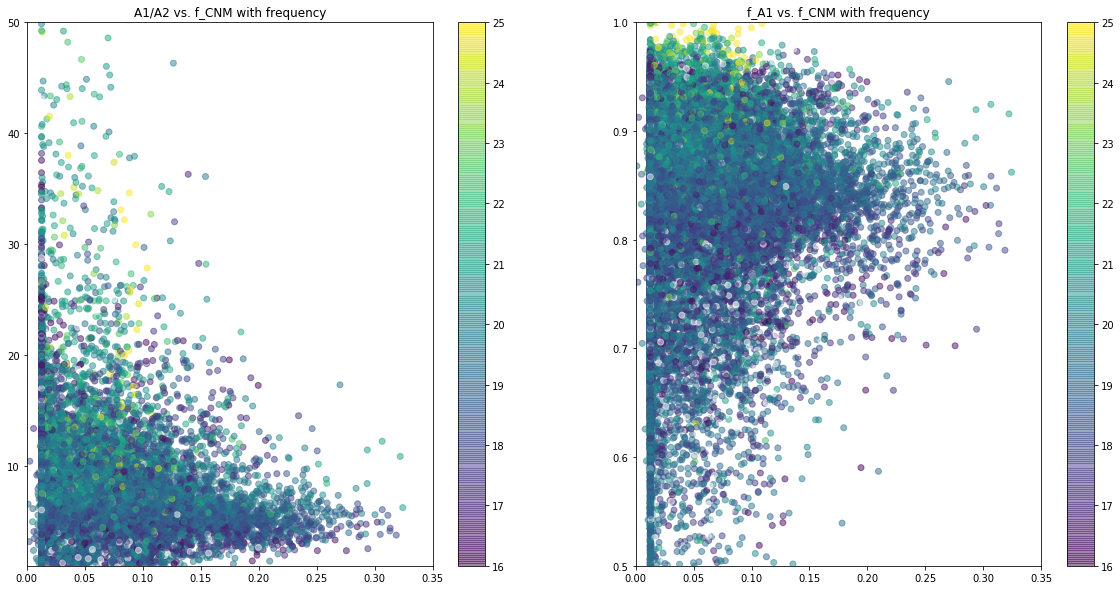

In [23]:
r = a1/a2
fa1 = a1/(a1+a2)
fa2 = a2/(a1+a2)

fig, ax = plt.subplots(1,2, figsize=(20,10))

#plots ratio of two amplitued vs. f_CNM
a = ax[0].scatter(fCNM, r, alpha=.5, c=nup1, vmin=16, vmax=25)
ax[0].set_ylim(1,50)
ax[0].set_xlim(0, .35)
ax[0].set_title('A1/A2 vs. f_CNM with frequency')
fig.colorbar(a, ax=ax[0])

#plots fraction of total amplitude included in primary map vs. f_CNM
b = ax[1].scatter(fCNM, fa1, alpha=.5, c=nup1, vmin=16, vmax=25)
ax[1].set_ylim(.5,1)
ax[1].set_xlim(0,.35)
ax[1].set_title('f_A1 vs. f_CNM with frequency')
fig.colorbar(b, ax=ax[1])

TypeError: histogram2d() got an unexpected keyword argument 'normed'

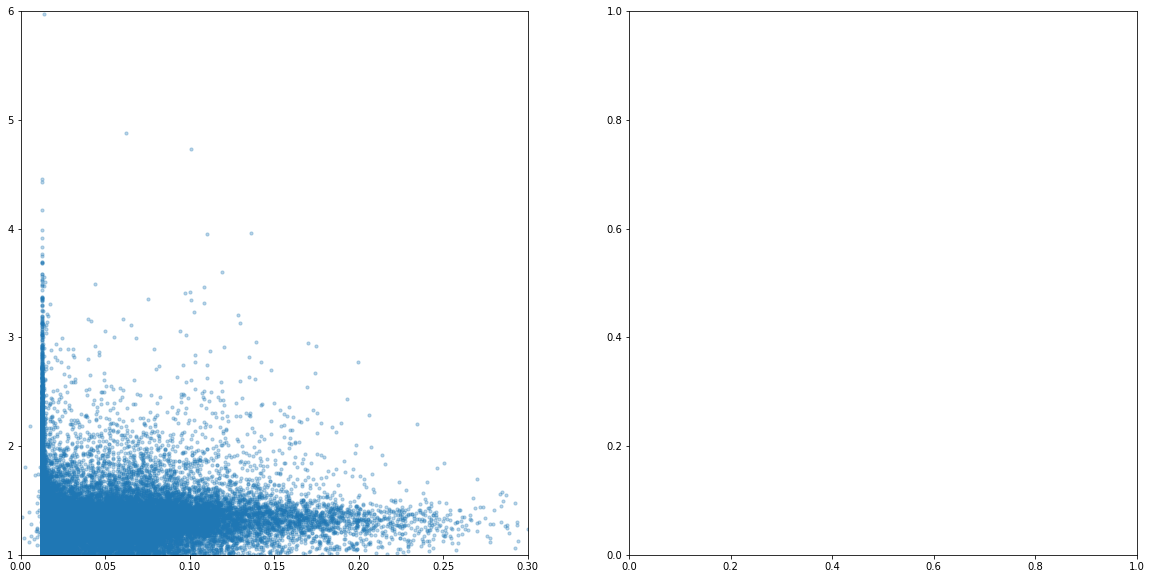

In [30]:
#ratio of I(20 GHz)/I(30 GHz) for various pixels plotted against f_CNM

idx = np.random.choice(np.arange(len(f_CNM)), 10000, replace=False)
b = len(a1) #number of pixels to be plotted

I_20 = I(a1, a2, nup1, nu_sd, f, 20)
I_30 = I(a1, a2, nup1, nu_sd, f, 30)

y = I_20/I_30

fig, ax = plt.subplots(1,2, figsize=(20,10))

a = ax[0].scatter(fCNM, y, s=10, alpha=.3)
ax[0].set_ylim(1,6)
ax[0].set_xlim(0, .3)

b = ax[1].hist2d(fCNM, y, bins=20, range=[[0, .2], [0, 4]])

for i in range(2):
    ax[i].set_title('I_20/I_30 vs. f_CNM')
    ax[i].set_xlabel('f_CNM')
    ax[i].set_ylabel('I(20)/I(30)')

Red is high, Blue is low


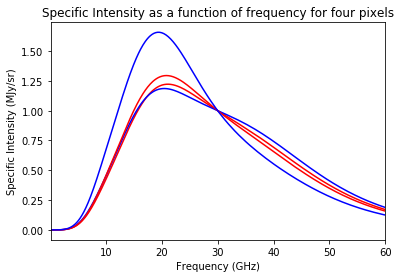

In [31]:
#Compares specific intensity curves for random points with low f_CNM to random points with high f_CNM

idx = np.random.choice(np.arange(len(f_CNM)), 300000, replace=False)

m_hi, m_lo = [], []
n_hi, n_lo = [], []
nu_p_hi, nu_p_lo = [], []
f_CNM_hi, f_CNM_lo = [], []

for i in idx:                        #creates bins of high and low f_CNM pixels, fills empty lists with their parameters 
    if 0 < f_CNM[i] < 0.02:
        m_lo.append(m[i])
        n_lo.append(n[i])
        nu_p_lo.append(nu_p[i])
        f_CNM_lo.append(f_CNM[i])
    elif 0.29 < f_CNM[i] < 0.31:
        m_hi.append(m[i])
        n_hi.append(n[i])
        nu_p_hi.append(nu_p[i])
        f_CNM_hi.append(f_CNM[i])

pix_lo = []
pix_hi = []
for i in range(2):                    #selects four random pixels, two each from high and low bins
    x = random.randint(0, len(m_lo))
    pix_lo.append(x-1)
    y = random.randint(0, len(m_hi))
    pix_hi.append(y-1)
    
b = len(pix_lo)                       #number of pixels to be plotted
nu = np.linspace(.1, 1000, len(m_lo)) #creates a range of values nu

for i in range(b):
    a1_lo = m_lo[pix_lo[i]] 
    a2_lo = n_lo[pix_lo[i]] 
    nup1_lo = nu_p_lo[pix_lo[i]] 
    I_nulo = I(a1_lo, a2_lo, nup1_lo, nu_sd, f, nu) 
    I_30lo = I(a1_lo, a2_lo, nup1_lo, nu_sd, f, 30)
    
    a1_hi = m_hi[pix_hi[i]] 
    a2_hi = n_hi[pix_hi[i]] 
    nup1_hi = nu_p_hi[pix_hi[i]]
    I_nuhi = I(a1_hi, a2_hi, nup1_hi, nu_sd, f, nu)
    I_30hi = I(a1_hi, a2_hi, nup1_hi, nu_sd, f, 30)
    
    plt.plot(nu, I_nuhi/I_30hi, 'r')
    plt.plot(nu, I_nulo/I_30lo, 'b')

    #print('f_CNM: ' + str(f_CNM_hi[pix_hi[i]]*100))
    #print('f_CNM: ' + str(f_CNM_lo[pix_lo[i]]*100))

    plt.xlim(.1,60)
    plt.title('Specific Intensity as a function of frequency for four pixels')
    plt.xlabel('Frequency (GHz)')
    plt.ylabel('Specific Intensity (MJy/sr)')

print("Red is high, Blue is low")

In [33]:
def I_bins(m, n, nu_p, nu):
    '''Calculates median and std curves of specific intensity vs. frequency for a given bin
    
    Input:  m: array, map of primary component
            n: array, map of secondary component
            nu_p: array, map of peak frequency for primary component
           
    Return: I_norm: array representing normalized median specific intensity
            std: array, standard deviation
            nu: array, frequency values for pixels involved'''
    b = np.array(range(len(m)))
    
    I_normed = np.empty((1,100))
    for i in b:
        a1 = m[i]
        a2 = n[i]
        nup = nu_p[i]
        
        Ii = np.array(I(a1, a2, nup, nu_sd, f, nu))
        I30 = np.array(I(a1, a2, nup, nu_sd, f, 30))

        Ii_norm = Ii/I30
        I_normed = np.vstack((I_normed, Ii_norm)) #makes ix100 array showing I; each row is one of n pixels, columns are distinct values of nu 
    
    I_median = np.median(I_normed, axis=0) #takes median of the columns of our array representing I    
    std = np.std(I_normed, axis=0)
    
    return I_median, std*(1/2)

4305
606
92
12


Text(0, 0.5, 'Specific Intensity (MJy/sr)')

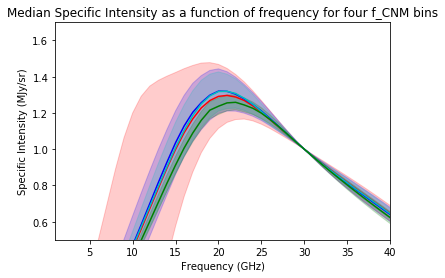

In [32]:
#Implements the function above to graph median SED curves for four bins of various f_CNM

idx = np.random.choice(np.arange(len(f_CNM)), 10000, replace=False) #picks a set of pixels from the length of f_CNM

m_0, m_1, m_2, m_3, m_4, m_5 = ([] for i in range(6)) #creates 6 empty bins for m
n_0, n_1, n_2, n_3, n_4, n_5 = ([] for i in range(6)) #creates 6 empty bins for n
nu_p0, nu_p1, nu_p2, nu_p3, nu_p4, nu_p5 = ([] for i in range(6)) #creates 6 empty bins for nu_p
f_CNM0, f_CNM1, f_CNM2, f_CNM3, f_CNM4, f_CNM5 = ([] for i in range(6)) #creates 6 empty bins for f_CNM
    
for x in idx: #sorts the pixels into bins based on fCNM
    if 0 < f_CNM[x] <= 0.08:
        m_0.append(m[x])
        n_0.append(n[x])
        nu_p0.append(nu_p[x])
    elif 0.08 < f_CNM[x] <= 0.16:
        m_1.append(m[x])
        n_1.append(n[x])
        nu_p1.append(nu_p[x])
    elif 0.16 < f_CNM[x] <= 0.24:
        m_2.append(m[x])
        n_2.append(n[x])
        nu_p2.append(nu_p[x])
    elif 0.24 < f_CNM[x] <= 0.32:
        m_3.append(m[x])
        n_3.append(n[x])
        nu_p3.append(nu_p[x])

print(len(m_0))
print(len(m_1))
print(len(m_2))
print(len(m_3))

nu = np.linspace(1, 100, 100)

I0, std0 = I_bins(m_0, n_0, nu_p0, nu)
pos0 = I0 + std0
neg0 = I0 - std0
I1, std1 = I_bins(m_1, n_1, nu_p1, nu)
pos1 = I1 + std1
neg1 = I1 - std1
I2, std2 = I_bins(m_2, n_2, nu_p2, nu)
pos2 = I2 + std2
neg2 = I2 - std2
I3, std3 = I_bins(m_3, n_3, nu_p3, nu)
pos3 = I3 + std3
neg3 = I3 - std3

plt.plot(nu, I0, 'r')
plt.fill_between(nu, pos0, neg0, color='r', alpha = .2)
plt.plot(nu, I1, 'b')
plt.fill_between(nu, pos1, neg1, color='b', alpha = .2)
plt.plot(nu, I2, 'c')
plt.fill_between(nu, pos2, neg2, color='c', alpha = .2)
plt.plot(nu, I3, 'g')
plt.fill_between(nu, pos3, neg3, color='g', alpha = .2)

plt.xlim(1,40)
plt.ylim(0.5,1.7)
plt.title('Median Specific Intensity as a function of frequency for four f_CNM bins')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Specific Intensity (MJy/sr)')

In [68]:
def plot_bin(frequencies, med, pos, neg, col):
    ''' Plots a median line and standard deviation region
       
        Input:
          frequencies: array or float; range of nu to be plotted
          med: array; median values at each nu
          pos: array; values at each nu of median + one standard deviation
          neg: array; values at each nu of median - one standard deviation
          col: list; color with which to plot the bin
          
        Returns: plot
    '''
    plt.plot(frequencies, med, color=col)
    #plt.fill_between(frequencies, pos, neg, color=col, alpha=.7)
    return

/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less_equal
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/home/mdodici/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:

Text(0, 0.5, 'Specific Intensity (MJy/sr)')

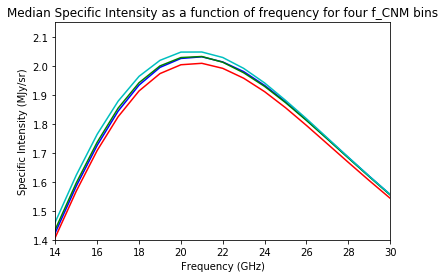

In [72]:
# Takes a different approach to the same task, creating a map of I(nu) at
# each integer nu, binning pixels from these maps by f_CNM, and plotting
# median SEDs with standard deviations for each bin.
nu = np.linspace(1, 60, 60)                                     #creates a range of frequency values, from 1 to 60 GHz

Im0, Im1, Im2, Im3 = (np.zeros(len(nu)) for i in range(4))      #creates four empty bins
Is0, Is1, Is2, Is3 = (np.zeros(len(nu)) for i in range(4)) 

low0, low1, low2, low3 = 0, 0.03, 0.06, 0.09
high0, high1, high2, high3 = 0.03, 0.06, 0.09, 0.12

I_normto = I(m, n, nu_p, nu_sd, f, 40)                          #maps I at nu=30

for i, freq in enumerate(nu):                                   #makes array with each row being a certain frequency
    I_nu = I(m, n, nu_p, nu_sd, f, freq)                        #calculates pixel values for nu = i
    I_normalize = I_nu/I_normto

    Im0[i] = np.median(I_normalize[(f_CNM > low0) & (f_CNM <= high0)])
    Im1[i] = np.median(I_normalize[(f_CNM > low1) & (f_CNM <= high1)])
    Im2[i] = np.median(I_normalize[(f_CNM > low2) & (f_CNM <= high2)])
    Im3[i] = np.median(I_normalize[(f_CNM > low3) & (f_CNM <= high3)])

    Is0[i] = np.std(I_normalize[(f_CNM > low0) & (f_CNM <= high0)])
    Is1[i] = np.std(I_normalize[(f_CNM > low1) & (f_CNM <= high1)])
    Is2[i] = np.std(I_normalize[(f_CNM > low2) & (f_CNM <= high2)])
    Is3[i] = np.std(I_normalize[(f_CNM > low3) & (f_CNM <= high3)])

plot_bin(nu, Im0, Im0+Is0, Im0-Is0, 'r')
plot_bin(nu, Im1, Im1+Is1, Im1-Is1, 'b')
plot_bin(nu, Im2, Im2+Is2, Im2-Is2, 'g')
plot_bin(nu, Im3, Im3+Is3, Im3-Is3, 'c')

#plt.xscale('log')
#plt.yscale('log')
plt.xlim(14,30)
plt.ylim(1.4,)
plt.title('Median Specific Intensity as a function of frequency for four f_CNM bins')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Specific Intensity (MJy/sr)')